# Introduction to machine learning

*Maxime Sangnier*

Fall, 2019

## Practical session 3: nonparametric and ensemble methods

# Table of contents
1. [Nonparametric methods](#part1)
    - [k-nearest neighbors](#part1sec1)
    - [Decision trees](#part1sec2)
1. [Ensemble methods](#part2)
    - [Bagging](#part2sec1)
1. [Random forests](#part3)
1. [Model selection](#part4)


In [1]:
from mllab import *


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



# Nonparametric methods <a id="part1"></a>
## k-nearest neighbors <a id="part1sec1"></a>


>Given a training dataset $\{(X_1, Y_1), \dots, (X_n, Y_n)\}$, the k-nearest neighbors rule consists in predicting, for $x \in \mathbb R^d$, the majority vote (for classification, or the mean for regression) of the k-nearest neighbors of $x$.
Formally, the predicted class is:
$$
    g(x) \in \operatorname{arg\,max}_{y \in \mathcal Y} \sum_{i=1}^k \mathbb 1_{Y_{(i)}=y},
$$
where the ranked labeled $\{Y_{(1)}, \dots, Y_{(n)}\}$ are such that $\|X_{(1)}-x\| \le \dots \le \|X_{(n)}-x\|$.

>Given the following dataset, train a [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and display the data along with the classification regions.

>What is the default metric?

<span style="color:blue">The default metric is the standard Euclidian norm.</span>

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_classes=4,
                           n_features=2, n_redundant=0, n_clusters_per_class=1)

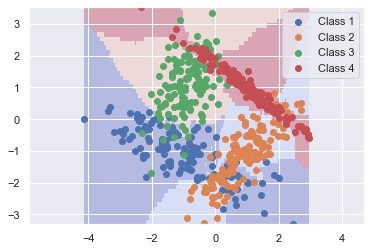

In [3]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 
plotXY(X, y)
map_regions(neigh, X)

>Repeat this experiment while making the number of neareset neighbors vary.
Display the results on several subplots with the classification score indicated in the title.

>What appens in the extreme situations where the number of nearest neighbors is either $1$ or $n$ (the size of the training set)?

<span style="color:blue">On observe de l'over-fitting en prenant $k=1$ et de l'under-fitting en prenant $k=50$.</span>

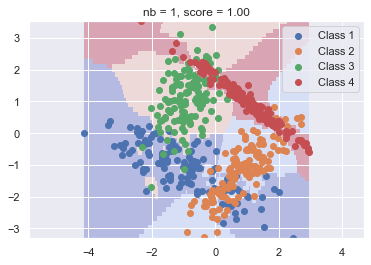

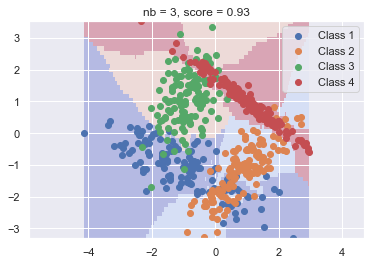

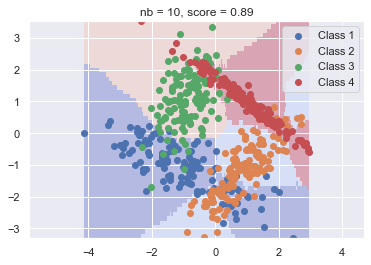

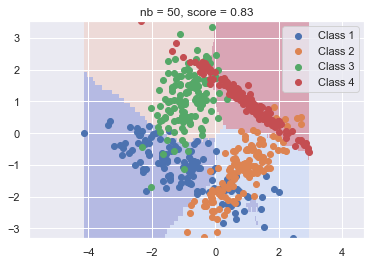

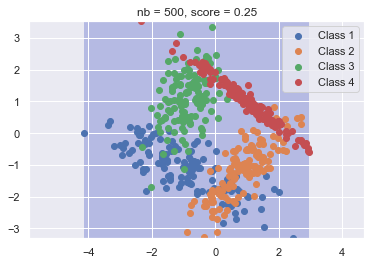

In [6]:
for k in [1, 3, 10, 50, 500]:
    neigh = KNeighborsClassifier(n_neighbors= k)
    neigh.fit(X, y) 
    plotXY(X, y)
    map_regions(neigh, X)
    plt.title('k = %d, score = %0.2f' % (k, neigh.score(X, y)))
    plt.show()

>For a point $x \in \mathbb R^d$, the predicted class is given by the majority vote
$$
    g(x) \in \operatorname{arg\,max}_{y \in \mathcal Y} \sum_{i=1}^k \mathbb 1_{Y_{(i)}=y},
$$
where the ranked labeled $\{Y_{(1)}, \dots, Y_{(n)}\}$ are such that $\|X_{(1)}-x\| \le \dots \le \|X_{(n)}-x\|$.

>We would like, for a while, to weight the vote of each neighbor in the prediction by $e^{-\gamma \|X_{(j)}-x\|^2}$, such that the new classification rule is
$$
    g_\gamma(x) \in \operatorname{arg\,max}_{y \in \mathcal Y} \sum_{i=1}^k e^{-\gamma \|X_{(i)}-x\|^2} \mathbb 1_{Y_{(i)}=y}.
$$

>Again with subplots and score prints, assess the impact of the parameter $\gamma$.
For this purpose, you may want to define the `weights` parameter of the [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to $x \mapsto e^{-\gamma x^2}$, using a lambda function.

>Relevant values for $\gamma$ are $\{10^{-3}, \dots, 10^4\}$ and `n_neighbors` can be set to $10$.

<span style="color:blue">Les valeurs très importantes de $\gamma$ écrasent les distances entre les points : tous les points sont à une distance nulle les uns des autres, ce qui fait que la classe majoritaire est prédite dans la majorité de l'espace. Pour des valeurs plus faibles de $\gamma$, on n'observe pas de différence significative entre les plots.</span>

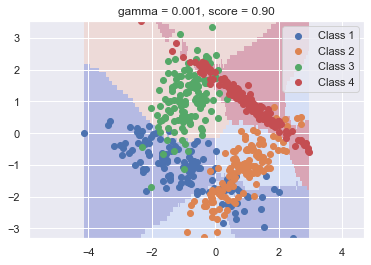

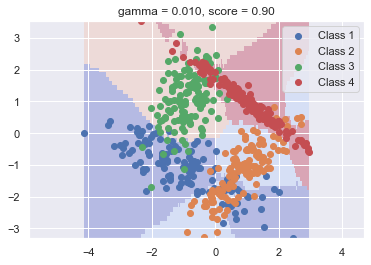

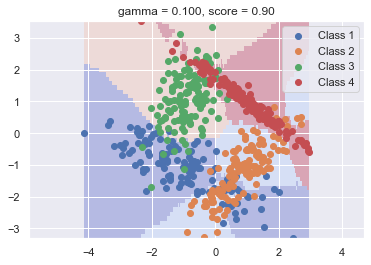

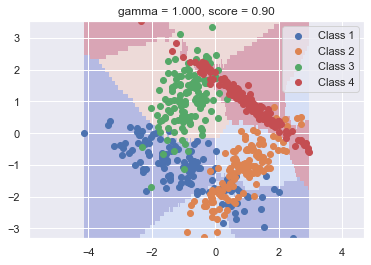

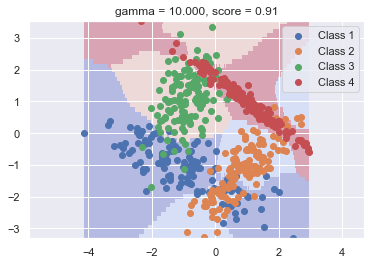

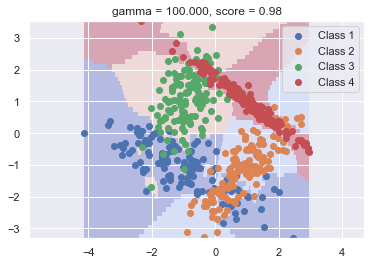

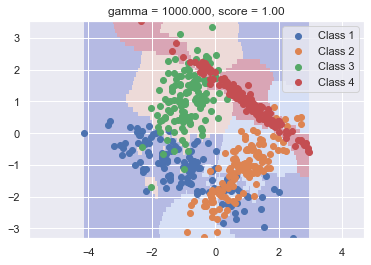

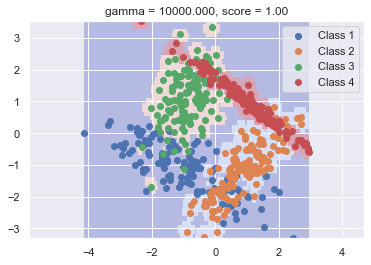

In [10]:
n_neighbors = 10
gamma_range = np.logspace(-3, 4, 8, base=10)

for gamma in gamma_range:
    neigh = KNeighborsClassifier(n_neighbors= n_neighbors, weights= (lambda x: np.exp(-gamma * x**2)))
    neigh.fit(X, y) 
    plotXY(X, y)
    map_regions(neigh, X)
    plt.title('gamma = %0.3f, score = %0.2f' % (gamma, neigh.score(X, y)))
    plt.show()

>Using the [train\_test\_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function, split the dataset into a training and a test set with ratio $0.2-0.8$.
Plot the test accuracy with respect to the number of neighbors.

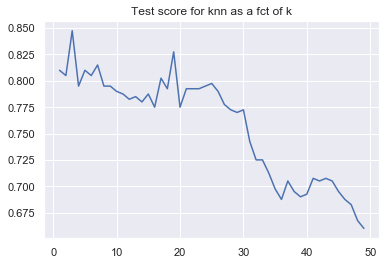

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
ks = range(1, 50)
scores = []

for k in ks:
    neigh = KNeighborsClassifier(n_neighbors= k)
    neigh.fit(X_train, y_train) 
    scores.append(neigh.score(X_test, y_test))

plt.plot(ks, scores)
plt.title('Test score for knn as a fct of k')
plt.show()

>Repeat the random split 20 times and plot the mean and the variance of the test accuracy.
What can you say about the variance of this estimator?

In [35]:
from sklearn.model_selection import train_test_split

repeats = 20
ks = range(1, 50)
scores = np.zeros((len(ks), repeats))

for r in range(repeats):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    for k in ks:
        neigh = KNeighborsClassifier(n_neighbors= k)
        neigh.fit(X_train, y_train) 
        scores[k-1][r] = neigh.score(X_test, y_test)

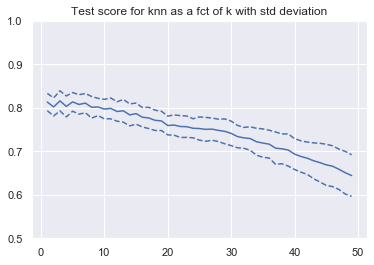

In [37]:
plt.ylim([0.5, 1])
plt.plot(ks, np.mean(scores, axis=1) + np.std(scores, axis=1), c='b', ls='--')
plt.plot(ks, np.mean(scores, axis=1) - np.std(scores, axis=1), c='b', ls='--')
plt.plot(ks, np.mean(scores, axis=1), c='b')
plt.title('Test score for knn as a fct of k with std deviation')
plt.show()

<span style="color:blue">La variance augmente à mesure que k augmente. (On représente une sorte d'intervalle de confiance plutôt que la variance.)</span>

>Let us consider the last random split.
Using the [crossval\_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function, find (and print) a good value for the number of nearest neighbors.

>For this parameter, compare the crossvalidation score and the test accuracy.

In [47]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
cross_scores = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train)) for k in range(1, 20)]
best = np.argmax(cross_scores)
best_classifier = KNeighborsClassifier(best+1).fit(X_train, y_train)

print('Best n_neighbor: %d' % best)
print('Crossvalidation score: %0.2f' % cross_scores[best])
print('Test accuracy: %0.2f' % best_classifier.score(X_test, y_test))

Best n_neighbor: 6
Crossvalidation score: 0.84
Test accuracy: 0.80


<span style="color:blue"> Le score en validation croisée est supérieur au score de test. </span>

>Plot the confusion matrix for the best classifier obtained.

In [89]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_pred, y, classes=None, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    cm = confusion_matrix(y, y_pred)
    
    if classes is None:
        classes = np.unique(y)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Unnormalized confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim([-0.5, classes[-1] + 0.5])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid()

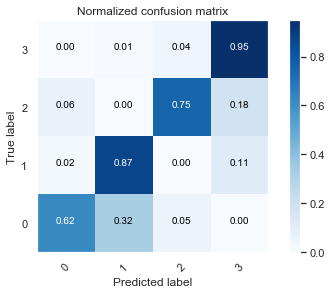

In [90]:
plot_confusion_matrix(best_classifier.predict(X_test), y_test, normalize=True)

## Decision trees <a id="part1sec2"></a>


>Decision trees, and in particular classification and regression trees (CART), are supervised estimators introduced by Leo Breiman et al.
The paradigm of a binary decision tree is to recursively split the space $\mathcal X$ with simple rules such that: is the explicative variable $x_j$ greater than the threshold $\tau$ or not?
Doing so, a decision tree is built, for which each node corresponds to a simple rule (and secondarly to a partition cell of $\mathcal X$).
The final result is a partition of $\mathcal X$ by hypercubes.

>At each step of the learning algorithm, 
1. consider the partition $\mathcal P = \{\mathcal X\}$;
1. for each cell $\mathcal A$ of $\mathcal P$, define the two-cell partition
$\mathcal A = \mathcal L_{j, \tau} \cup \mathcal R_{j, \tau}$, where $j \in [d]$ is a feature index and $\tau \in \mathbb R$ is a threhold, and
$$
    \begin{cases}
        \mathcal L_{j, \tau} = \left\{ x \in \mathcal A :  x_j \le \tau \right\}\\
        \mathcal R_{j, \tau} = \left\{ x \in \mathcal A :  x_j > \tau \right\}
        %= \mathcal A \backslash \mathcal L_{j, \tau}.
    \end{cases}
$$
are the "left" and "right" parts of $\mathcal A$.
Then, find the best pair (feature, threhold) for splitting:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{\left| \mathcal L_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal L_{j, \tau}) +
    \frac{\left| \mathcal R_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal R_{j, \tau})
$$
where $D$ is a distortion measure for a cell (see below);
1. replace $\mathcal A$ by $\mathcal L_{j, \tau}$ and $\mathcal R_{j, \tau}$ in the partition $\mathcal P$;
1. go to 2.

>Given a cell $\mathcal A$, one may define the ratio of observations of $\mathcal A$ of class $y \in \mathcal Y$:
$$
    p_y(\mathcal A) = \frac{\left| \left\{ i \in [n] : X_i \in \mathcal A, Y_i=y \right\} \right|}{\left| \mathcal A \right|}.
$$

>Then, the distortion of the cell $\mathcal A$ may be:
- Gini impurity: $D(\mathcal A) = \sum_{y \in \mathcal Y} p_y(\mathcal A) (1-p_y(\mathcal A))$ (classification);
- entropy: $D(\mathcal A) = - \sum_{y \in \mathcal Y} p_y(\mathcal A) \log(p_y(\mathcal A))$ (classification);
- mean squared error: $D(\mathcal A) = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} \left( Y_i - \bar Y_{\mathcal A} \right)^2$, with $\bar Y_{\mathcal A} = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} Y_i$ (regression).

>For regression, Jerome Friedman suggested an improved criterion (in its original paper tackling gradient boosting), referred to as Friedman's mean squared error:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{ \left| \mathcal L_{j, \tau} \right| \left| \mathcal R_{j, \tau} \right| }{ \left| \mathcal L_{j, \tau} \right| + \left| \mathcal R_{j, \tau} \right| }
    \left( \bar Y_{\mathcal L_{j, \tau}} - \bar Y_{\mathcal R_{j, \tau}} \right)^2.
$$

>Last be not least, several stopping rules are of interests:
- maximal depth of the tree;
- minimal number of observations required to split an internal node;
- minimal number of observations required to be at a leaf node;
- maximal number of leaf nodes.

>We would like to assess the accuracy of a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with respect to the kind of splitting criterion (Gini impurity or entropy) and to the maximal depth allowed.

>For this purpose, fit a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) on the previous dataset and plot 4 curves depicting the classification error for:
1. the train set and the Gini impurity;
1. the test set and the Gini impurity;
1. the train set and the entropy;
1. the test set and the entropy.

>What can you conclude based on this numerical experiment?

In [102]:
from sklearn.tree import DecisionTreeClassifier
errors = {'gini':{}, 'entropy':{}}
depth_range = range(1, 12)

for criterion in ["gini", "entropy"]:
    errors[criterion]['train'] = []
    errors[criterion]['test'] = []
    for depth in depth_range:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        clf.fit(X_train, y_train)
        errors[criterion]['train'].append(clf.score(X_train, y_train))
        errors[criterion]['test'].append(clf.score(X_test, y_test))

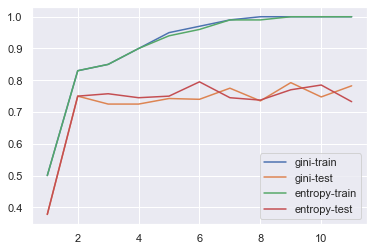

In [103]:
plt.plot(depth_range, errors['gini']['train'], label='gini-train')
plt.plot(depth_range, errors['gini']['test'], label='gini-test')
plt.plot(depth_range, errors['entropy']['train'], label='entropy-train')
plt.plot(depth_range, errors['entropy']['test'], label='entropy-test')
plt.legend()
plt.show()

<span style="color:blue">Both splitting criterions have similar performance, and the scores reach a plateau for depth values superior to 2.</span>

>Map the regions of the "best" (with respect to the test error) decision tree obtained with the Gini impurity.

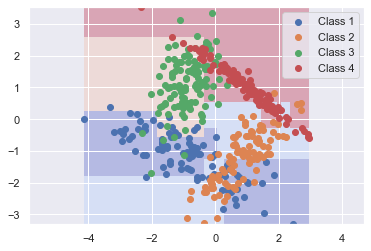

In [112]:
best = np.argmax(errors['gini']['test'])
clf = DecisionTreeClassifier(criterion='gini', max_depth=best+1)
clf.fit(X_train, y_train)
plotXY(X_test, y_test)
map_regions(clf, X_test)

# Ensemble methods <a id="part2"></a>
## Bagging <a id="part2sec1"></a>


>Bagging is a portmanteau word for *bootstrap aggregating*.
The paradigm of bagging is to train independently several base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, and to build a new classifier by averaging the predictions of the base classifiers:
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
Doing so, the variance of the prediction is reduced and so it is for the global error.
The requirements for such a result are:
- base classifiers should be more accurate than chance;
- base classifiers should be estimated independently from each other.

>In practice, base classifiers are trained *quasi-independently* by bootstrapping the training set.

>Bagging is also valid for multiclass problems: for $C$ classes, the prediction is:
$$
    g_n^T(x)
    = \operatorname{arg\,max}_{1 \le j \le C} \frac{1}{T} \sum_{t=1}^T g_t(x) \mathbb 1_{g_t(x)=j}
    = \operatorname{arg\,max}_{1 \le j \le C} \operatorname{card} \left( \left\{ t \in [T] : g_t(x) \mathbb 1_{g_t(x)=j} \right\} \right),
$$
where $g_t \colon \mathbb R^d \to [C]$, which corresponds to the majority vote since base classifiers are equally weighted.

>Finally, one may also bag regressors $g_t \colon \mathbb R^d \to \mathbb R$ by a simple averaging:
$$
    g_n^T(x) = \frac{1}{T} \sum_{t=1}^T g_t(x).
$$

>Assume that we are provided with a sequence of independent classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, such that classifiers are equally good: there exists $p>0.5$ such that $\mathbb P(g_t(X)=Y) = p$ for all $t \in [T]$.
We now consider the bagged classifier
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
What is the distribution of the random variable $\sum_{t=1}^T \mathbb 1_{g_t(X)=Y}$?
Plot its probability mass function for $T=9$ and $p=0.7$.

<span style="color:blue">The random variable $\sum_{t=1}^T \mathbb 1_{g_t(X)=Y}$ follows a binomial distribution $B(T, p)$.</span>

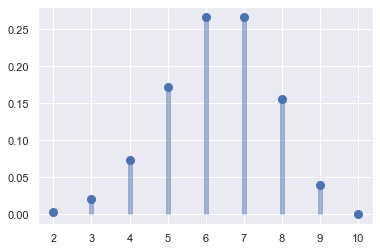

In [133]:
from scipy.stats import binom
T = 9
p = 0.7
x = np.arange(2, 11)
plt.plot(x, binom.pmf(x, T, p), 'bo', ms=8, label='binom pmf')
plt.vlines(x, 0, binom.pmf(x, T, p), colors='b', lw=5, alpha=0.5)
plt.show()

>For these particular values of $T$ and $p$, compute numerically $\mathbb P(g_n^T(X)=Y)$.

<span style="color:blue">We have

$$\mathbb P(g_n^T(X)=Y) = 1 - \Phi_{T, p}\left(\frac{T}{2}\right)$$

<span style="color:blue">with $\Phi_{T, p}$ the cumulative distribution function of the binomial distribution $B(T, p)$.</span>

In [134]:
'Probability of success: %0.3f' % (1-binom.cdf(T/2, T, p))

'Probability of success: 0.901'

>Plot the probability of success (or accuracy) with respect to the number of base classifiers $T \in \{1, 2, 3, \dots, 49\}$ (the formula used previously is only valid for odd numbers) for $p \in [0.55, 0.65, \dots, 0.95]$.

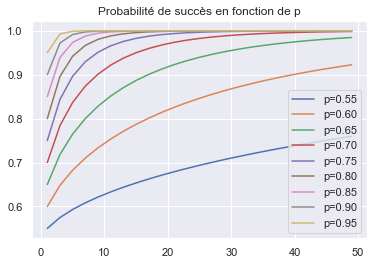

In [135]:
T_range = range(1, 50, 2)
for p in np.arange(0.55, 1, 0.05):
    plt.plot(T_range, [1-binom.cdf(T/2, T, p) for T in T_range], label='p=%0.2f' % p)
plt.legend()
plt.title('Probabilité de succès en fonction de p')
plt.show()

Complete the following script to implement bagging with regression trees.

In [155]:
from sklearn.tree import DecisionTreeRegressor

class BaggingTree(object):
    def __init__(self, n_estimators=10, max_depth=1, max_samples=1.0):
        """
        Parameters:
        - n_estimators: number of estimators
        - max_depth: maximal depth of the regressor tree
        - max_samples: ratio of samples to use for learning base regressors.
            - If max_samples=1.0: use bootstrap.
            - If max_samples<1.0: use random sampling and extract max_samples x n points
            (where n is the total numer of points).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_samples = max_samples
        
    def fit(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        n = X.shape[0]  # Sample size
        m = int(self.max_samples * n)  # Number of points for random sampling
        
        self.estimators_ = []
        for t in range(self.n_estimators):
            if self.max_samples==1:
                idx = np.random.randint(0, n, n)  # Bootstrap
            else:
                idx = np.random.permutation(n)[:int(self.max_samples*n)]  # Random sampling
            self.estimators_.append(DecisionTreeRegressor(max_depth=self.max_depth))
            self.estimators_[-1].fit(X[idx], y[idx])
    
    def predict(self, X):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        y = [reg.predict(X) for reg in self.estimators_]
        return np.mean(np.asarray(y), axis=0)
    
    def error(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        return np.sum((y - self.predict(X))**2)

>Apply bagging to the following regression dataset and plot (on the same figure), the training data and the prediction for test data.

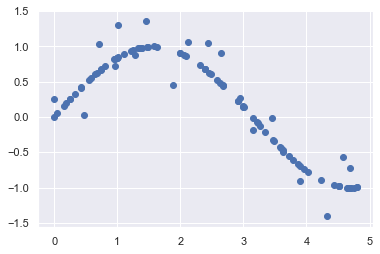

In [145]:
# Regression dataset
n = 100
X_train = np.sort(5 * np.random.rand(n))
y_train = np.sin(X_train)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))

X_test = np.arange(0, 5, step=1e-2)
y_test = np.sin(X_test)

# Make 2d-arrays
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

plt.scatter(X_train, y_train)

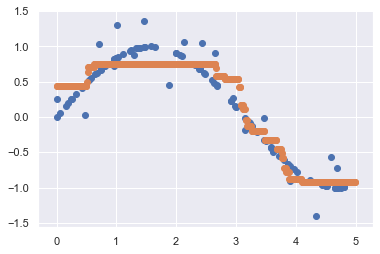

In [147]:
plt.scatter(X_train, y_train)
reg = BaggingTree(max_depth=2)
reg.fit(X_train, y_train)
plt.scatter(X_test, reg.predict(X_test))
plt.show()

>Analyze the behavior of the prediction curve and of the test error with respect to the maximal depth of decision trees and to the number of base regressors.

<span style="color:blue">We observe that the test error decreases with a greater maximal depth. With a maximal depth of 5, adding new estimators lead to overfitting.</span>

Test error: 15.856279932133468


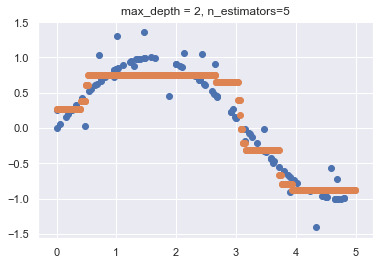

Test error: 14.633437420888162


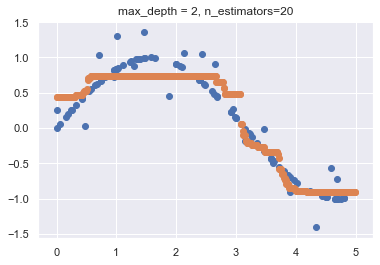

Test error: 3.394228344907532


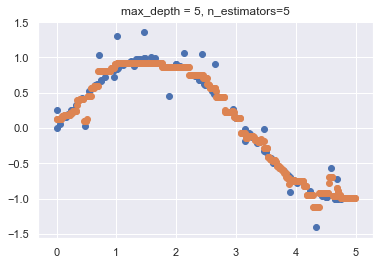

Test error: 3.522588198947147


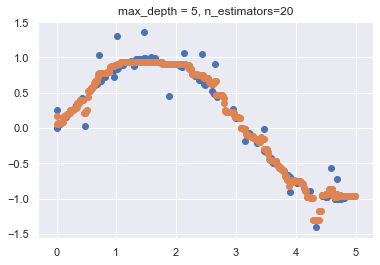

In [161]:
for depth in [2, 5]:
    for n_reg in [5, 20]:
        reg = BaggingTree(max_depth=depth, n_estimators=n_reg)
        reg.fit(X_train, y_train)
        print('Test error: ' + str(reg.error(X_test, y_test)))
        plt.scatter(X_train, y_train)
        plt.scatter(X_test, reg.predict(X_test))
        plt.title('max_depth = %d, n_estimators=%d' % (depth, n_reg))
        plt.show()

>We consider decision trees with `max_depth = 5`.
Plot two curves (one with bootstrap and one with 25%-subsampling) showing the test error with respect to the number of base regressors.
What can we conclude?

<span style="color:blue">Subsampling yields smaller test errors compared to boostraping.</span>

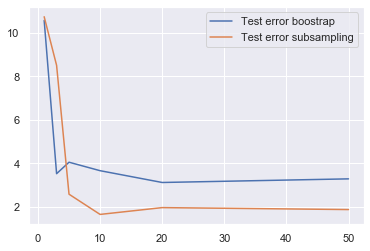

In [159]:
n_estimators = [1, 3, 5, 10, 20, 50]
max_depth = 5
score_bootstrap = []
score_subsampling = []

for k in n_estimators:
    reg_b = BaggingTree(max_depth=5, n_estimators=k, max_samples=1)
    reg_s = BaggingTree(max_depth=5, n_estimators=k, max_samples=0.25)
    reg_b.fit(X_train, y_train)
    reg_s.fit(X_train, y_train)
    score_bootstrap.append(reg_b.error(X_test, y_test))
    score_subsampling.append(reg_s.error(X_test, y_test))
    
plt.plot(n_estimators, score_bootstrap, label='Test error boostrap')
plt.plot(n_estimators, score_subsampling, label='Test error subsampling')
plt.legend()
plt.show()

# Random forests <a id="part3"></a>


>Random forests are bagged trees: for binary classification, a random forest is
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right),
$$
where the base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, are learned quasi-independently by bootstrap.

>However, in order to enforce the independent learning, each decision tree $g_t$ owns an additional randomization step in its learning procedure:
1. at each cell, select a subset of features at random;
1. find the best pair (feature, threshold) for splitting.

>The following script loads and preprocesses the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).
Explain each step and indicate its purpose.

>Is it useful for decision trees?

The data is split into a training set and a test set. Then both sets are standardized (null mean, unit variance). To be honest, I don't really see the advantage of standardizing for decision trees, as decision functions are "parallel to the axes".

In [200]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]

>On the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html), compare scikit-learn [bagging](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (with bootstrap and 25%-subsampling) and [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).
For this purpose, consider `max_depth = 5` and plot three curves showing the regression score for the test set with respect to the number of base regressors.
What can we conclude?

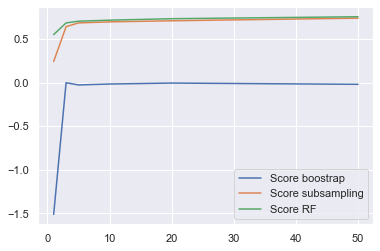

In [219]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

n_estimators = [1, 3, 5, 10, 20, 50]
max_depth = 5
score_bootstrap = []
score_subsampling = []
score_RF = []

for k in n_estimators:
    reg_b = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=k, max_samples=1)
    reg_s = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=k, max_samples=0.25)
    reg_rf = RandomForestRegressor(max_depth=5, n_estimators=k)
    reg_b.fit(X_train, y_train)
    reg_s.fit(X_train, y_train)
    reg_rf.fit(X_train, y_train)
    score_bootstrap.append(reg_b.score(X_test, y_test))
    score_subsampling.append(reg_s.score(X_test, y_test))
    score_RF.append(reg_rf.score(X_test, y_test))
    
plt.plot(n_estimators, score_bootstrap, label='Score boostrap')
plt.plot(n_estimators, score_subsampling, label='Score subsampling')
plt.plot(n_estimators, score_RF, label='Score RF')
plt.legend()
plt.show()

<span style="color:blue">The bootstrap bagging method performs surprisingly poorly. Subsampling and RF have approximately the same performance.</span>

# Model selection <a id="part4"></a>


>Load the [digits classification dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits), split it randomly and preprocess it similarly to the diabetes dataset (be careful, we are now handling a classification dataset).

In [201]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

data = load_digits()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

>We aim at comparing three models based on the [digits classification dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits):
1. [gradient boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html);
1. [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html);
1. [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

>For each model, some possible values of parameters are defined below.
Explain the role of these parameters.

In [203]:
# Grid parameters
tree_params = {"max_depth": [5, 10, 15],  # maximum depth of each tree
              "n_estimators": [10, 100]}  # number of trees
gb_params = tree_params.copy()  # Parameters for gradient boosting
gb_params.update({"learning_rate": np.logspace(-2, 0, num=3),   # learning rate, ie decay of the contribution of each additional tree
                 "max_features": [0.1]})    # number of features to consider at each split (bias-variance tradeoff) 
lr_params = {"C": np.logspace(-3, 3, num=7)}  # bias-variance tradeoff

>With the training set previously generated, perform a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) in order to determine "good" parameters among the ones proposed above.
Compare the test scores of the models trained with the "best" parameters.

In [204]:
# Auxiliary parameters
gs_params = {"cv": 3, "n_jobs": -1, "verbose": 1}

In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

tree_gb = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_params, **gs_params)
tree_gb.fit(X_train, y_train)

tree_rf = GridSearchCV(RandomForestClassifier(), param_grid=tree_params, **gs_params)
tree_rf.fit(X_train, y_train)

tree_lr = GridSearchCV(LogisticRegression(), param_grid=lr_params, **gs_params)
tree_lr.fit(X_train, y_train)

print('Test score GB: %0.2f' % tree_gb.score(X_test, y_test))
print('Test score RF: %0.2f' % tree_rf.score(X_test, y_test))
print('Test score LR: %0.2f' % tree_lr.score(X_test, y_test))


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.8s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Test score GB: 0.98
Test score RF: 0.98
Test score LR: 0.96


>The general pattern of this numerical experiment is:
1. spliting randomly the dataset;
1. preprocessing it;
1. finding suitable parameters by grid search;
1. assessing the generalization error.

>Repeat this experiment 20 times and record the score for each method and each run.
Print the mean score and the standard deviation for each method.

In [214]:
n_repeats = 20
scores = np.zeros((3, n_repeats))

for r in range(n_repeats):
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    tree_gb = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_params, **gs_params)
    tree_gb.fit(X_train, y_train)
    scores[0][r] = tree_gb.score(X_test, y_test)

    tree_rf = GridSearchCV(RandomForestClassifier(), param_grid=tree_params, **gs_params)
    tree_rf.fit(X_train, y_train)
    scores[1][r] = tree_rf.score(X_test, y_test)

    tree_lr = GridSearchCV(LogisticRegression(), param_grid=lr_params, **gs_params)
    tree_lr.fit(X_train, y_train)
    scores[2][r] = tree_lr.score(X_test, y_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.6s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.3s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.2s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.1s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.8s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.7s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.4s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.7s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.1s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.4s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.6s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.2s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.4s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.5s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.6s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.8s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.3s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.1s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.3s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.4s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.3s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.8s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.2s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.1s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.1s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.1s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.3s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.8s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.3s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   26.2s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.6s finished
/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.4s finished


In [215]:
print('Mean for GB: %0.2f and std dev: %0.2f' % (np.mean(scores[0]), np.std(scores[0])))
print('Mean for RF: %0.2f and std dev: %0.2f' % (np.mean(scores[1]), np.std(scores[1])))
print('Mean for LR: %0.2f and std dev: %0.2f' % (np.mean(scores[2]), np.std(scores[2])))

Mean for GB: 0.98 and std dev: 0.01
Mean for RF: 0.97 and std dev: 0.01
Mean for LR: 0.96 and std dev: 0.01


>Perform a [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html) to assess the difference between the mean scores of Gradient boosting and random forests.

In [216]:
from scipy.stats import wilcoxon
wilcoxon(scores[0], scores[1])

WilcoxonResult(statistic=26.0, pvalue=0.016152835493945302)